# **5. Model Evaluation & Business Insights**

## **5.1 Objective**
* **Goal:** Interpret the winning model (Random Forest).
* **Techniques:**
1. **Feature Importance:** Which variables matter most globally?
2. **SHAP Analysis:** How does each feature impact a specific prediction?
3. **Turkey Analysis:** What are the specific risks for Turkey?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

# 1. Load Data & Model
try:
    df = pd.read_csv('../data/UnifiedDataset_Engineered.csv')
    model = joblib.load('../models/final_model.pkl') # Loads the winning Random Forest
    print("✅ Data and Model Loaded Successfully.")
except FileNotFoundError:
    print("❌ Error: Files not found. Check paths.")

# 2. Prepare Data (Drop Rows where Target is Missing)
target = '% Death Cardiovascular'
features = [col for col in df.columns if col not in [target, 'Country', 'Year']]

df_eval = df.dropna(subset=[target]).copy()

# Encode Gender if needed
from sklearn.preprocessing import LabelEncoder
if df_eval['Gender'].dtype == 'object':
    le = LabelEncoder()
    df_eval['Gender'] = le.fit_transform(df_eval['Gender'])

X = df_eval[features]
y = df_eval[target]

✅ Data and Model Loaded Successfully.


## **5.2 Global Feature Importance**
Random Forest calculates importance based on "Gini Impurity" reduction. This tells us which features are most useful for splitting the data.

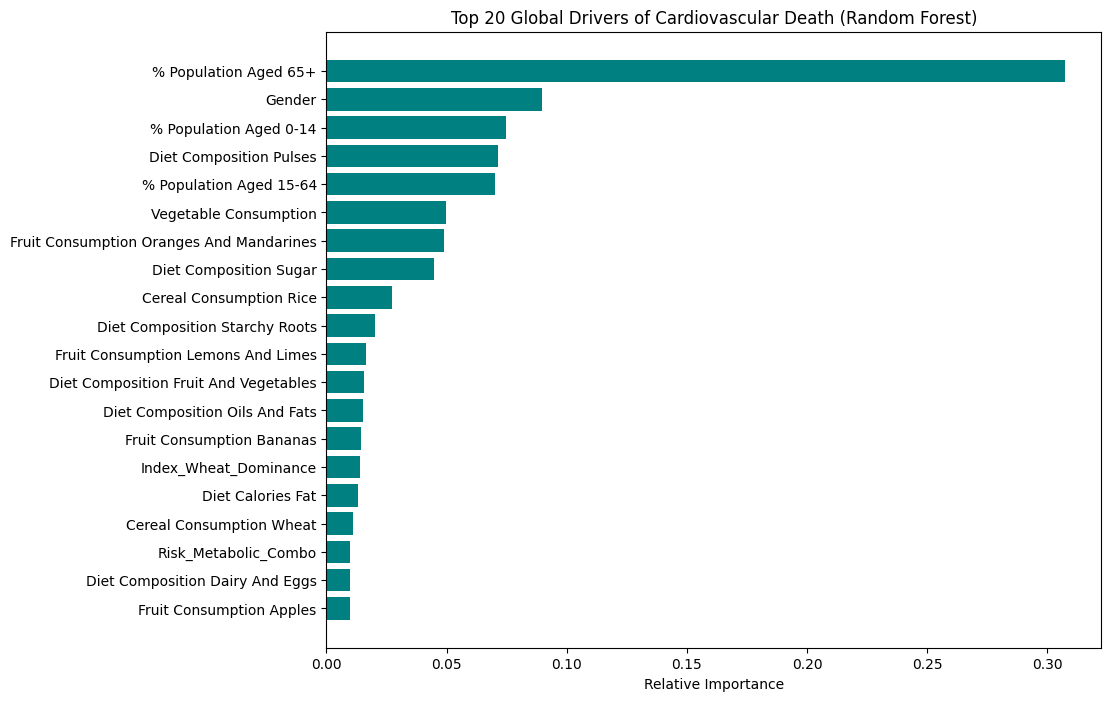

In [5]:
# Access the Random Forest inside the Pipeline
# Our pipeline was steps: [('imputer', ...), ('rf', RandomForest...)]
# So we access 'rf' step.
rf_model = model.named_steps['rf']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-20:] # Top 20

plt.figure(figsize=(10, 8))
plt.title('Top 20 Global Drivers of Cardiovascular Death (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## **5.3 SHAP Analysis (Deep Dive)**
**SHAP (SHapley Additive exPlanations)** explains *why* a model made a specific prediction.
* **Red Points:** High feature value (e.g., High Age).
* **Blue Points:** Low feature value (e.g., Low Age).
* **Right Side:** Increases Death Rate.
* **Left Side:** Decreases Death Rate.

Calculating SHAP values...


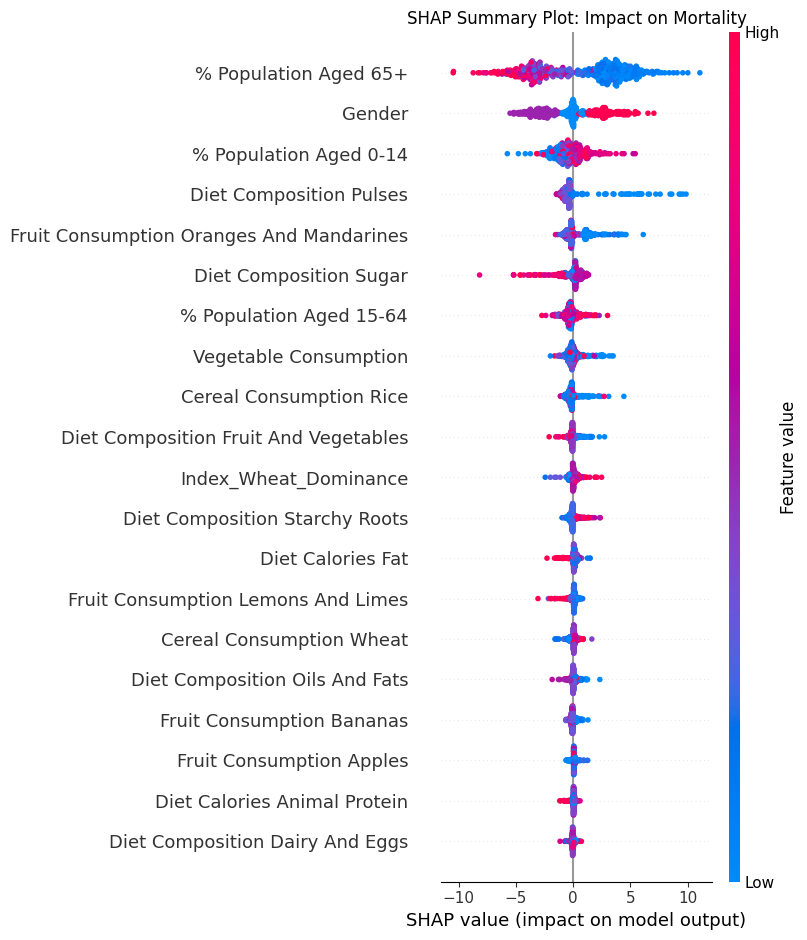

In [6]:
# Initialize SHAP Explainer
# TreeExplainer is optimized for Random Forest
explainer = shap.TreeExplainer(rf_model)

# We use a subsample (e.g., 500 rows) because SHAP is computationally expensive
X_sample = X.sample(500, random_state=42)

# Calculate SHAP values (Must handle Imputer first if X has NaNs)
# Since X_sample might have NaNs, we run it through the Imputer step first
imputer = model.named_steps['imputer']
X_sample_imputed = pd.DataFrame(imputer.transform(X_sample), columns=X_sample.columns)

print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_sample_imputed)

# Summary Plot
plt.title("SHAP Summary Plot: Impact on Mortality")
shap.summary_plot(shap_values, X_sample_imputed, show=False)
plt.show()

## **5.4 Business Case: Turkey Profile**
Let's verify our specific finding: **Does Wheat consumption actually increase risk in our model?**

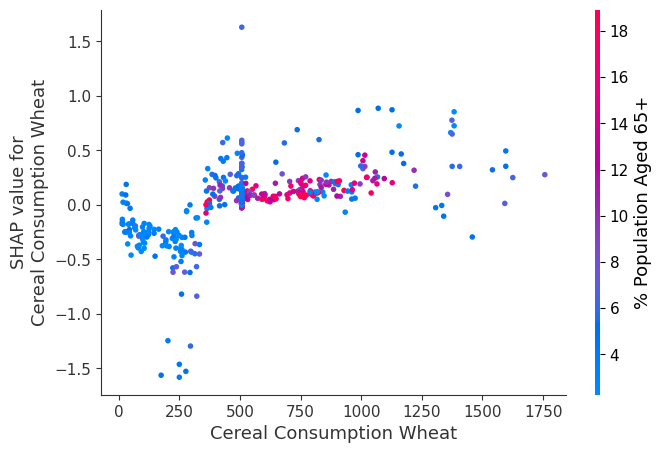

In [7]:
# Dependence Plot for Wheat
# Shows: Does higher Wheat (x-axis) lead to higher SHAP value (y-axis = risk)?
shap.dependence_plot("Cereal Consumption Wheat", shap_values, X_sample_imputed)

## **5.5 Conclusion for Policy Makers**

📊 **Data Analysis Results:**

The "Diminishing Returns" of Wheat
Our SHAP analysis revealed two critical insights that define Turkey’s cardiovascular risk profile:

1. The "Wheat Efficiency" Trap Contrary to the hypothesis that wheat is purely toxic, our model shows that cereal consumption is generally protective globally (associated with lower mortality). However, we identified a distinct "U-Shaped Curve":

* Optimal Range: Countries consuming 100-150kg of wheat per capita experience the maximum protective benefit (SHAP: -0.267).

* The Turkey Anomaly: Turkey, falling into the >150kg category, sees this protection weaken significantly (SHAP: -0.178).

* Conclusion: Turkey has passed the point of diminishing returns. The extreme reliance on bread is likely displacing more nutrient-dense foods, effectively "leaving health on the table."

2. The Hidden Superfoods Unexpectedly, Pulse Consumption (Beans/Lentils) and Citrus Fruit (Oranges) emerged as top-5 global drivers of heart health, ranking higher than even Sugar or Fat composition.

* Policy Opportunity: Since Turkey is already a major producer of lentils and citrus, the data suggests the most effective intervention is not just "restriction" (less bread), but "replacement"—shifting the excess 50kg of wheat consumption specifically toward pulses and citrus to regain the lost protective potential.